In [1]:
!pip install transformers accelerate peft datasets bitsandbytes sentencepiece scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 11.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import json
import random
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForCausalLM, AutoTokenizer,
    TrainingArguments, DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, PeftModel


In [3]:
df = pd.read_csv("DiseaseAndSymptoms.csv")
df.head()


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import pandas as pd
import json
import random

df = pd.read_csv("DiseaseAndSymptoms.csv")

# Combine all symptom columns into a comma-separated list
symptom_cols = [col for col in df.columns if col.startswith("Symptom")]
df["Symptoms"] = df[symptom_cols].fillna("").apply(lambda row:
                                                   ", ".join([s for s in row.values if isinstance(s, str) and s.strip() != ""]),
                                                   axis=1)

def format_record(symptoms, disease):
    return {
        "instruction": "Identify the disease pattern based on symptoms.",
        "input": symptoms,
        "output": (
            f"Disease: {disease}\n"
            f"Explanation: The symptoms provided match patterns commonly associated with {disease} in the dataset.\n"
            f"Note: This is not medical advice."
        )
    }

records = []
for _, row in df.iterrows():
    records.append(format_record(row["Symptoms"], row["Disease"]))

random.shuffle(records)

train_size = int(0.8 * len(records))

train_data = records[:train_size]
test_data  = records[train_size:]

with open("train.jsonl", "w") as f:
    for r in train_data:
        f.write(json.dumps(r) + "\n")

with open("test.jsonl", "w") as f:
    for r in test_data:
        f.write(json.dumps(r) + "\n")

print("JSONL files created successfully!")


JSONL files created successfully!


In [5]:
dataset = load_dataset("json", data_files={"train": "train.jsonl"})
dataset


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 3936
    })
})

In [6]:
import peft
print(peft.__version__)


0.18.0


In [7]:
!pip install -U git+https://github.com/huggingface/peft.git


  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-o_8ccwd0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-o_8ccwd0
  Resolved https://github.com/huggingface/peft.git to commit 5fbdd672f5591f69472b46f84b12ae443f9579e6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="CAUSAL_LM",
    target_modules=["c_attn"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [11]:
from datasets import load_dataset

# Load your JSONL file
dataset = load_dataset("json", data_files={"train": "train.jsonl"})
dataset = dataset["train"]

def preprocess(example):
    text = (
        f"Instruction: {example['instruction']}\n"
        f"Symptoms: {example['input']}\n"
        f"Response: {example['output']}"
    )
    tokens = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=256
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

tokenized_dataset = dataset.map(preprocess, batched=False)


Map:   0%|          | 0/3936 [00:00<?, ? examples/s]

In [12]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# Training configuration
training_args = TrainingArguments(
    output_dir="./gpt2-disease-lora",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    warmup_steps=20,
    learning_rate=2e-4,
    logging_steps=10,
    save_strategy="epoch",
    fp16=True,
    report_to="none"
)

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator
)

# Start training
trainer.train()

# Save LoRA adapter
model.save_pretrained("gpt2-disease-lora")


The model is already on multiple devices. Skipping the move to device specified in `args`.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,4.046700
20,3.885600
30,3.743500
40,3.480600
50,3.000200
60,2.637200
70,2.261400
80,1.915600
90,1.691600
100,1.513300


In [13]:
import json
import pandas as pd

# Load test data
test_df = pd.read_json("test.jsonl", lines=True)

def generate_response(symptoms):
    prompt = (
        f"Instruction: Identify the disease pattern based on symptoms.\n"
        f"Symptoms: {symptoms}\n"
        f"Response:"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=80,
        do_sample=False
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [15]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name() if torch.cuda.is_available() else "None")


CUDA available: True
GPU name: Tesla T4


In [16]:
next(model.parameters()).device


device(type='cuda', index=0)

In [17]:
len(test_df)


984

In [19]:
import torch
model.eval()
torch.set_grad_enabled(False)

import logging
logging.getLogger("transformers.generation").setLevel(logging.ERROR)
logging.getLogger("transformers.generation.utils").setLevel(logging.ERROR)

actual = []
predicted = []

for i, row in test_df.iterrows():

    symptoms = row["input"]
    actual_disease = row["output"].split("\n")[0].replace("Disease:", "").strip()

    prompt = f"""Instruction: Identify the disease pattern based on symptoms.
Symptoms: {symptoms}
Response:"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    output_ids = model.generate(
        **inputs,
        max_new_tokens=15,  # SUPER FAST
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False
    )

    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if "Disease:" in response:
        pred = response.split("Disease:")[1].split("\n")[0].strip()
    else:
        pred = "Unknown"

    actual.append(actual_disease)
    predicted.append(pred)

    if (i+1) % 25 == 0:
        print(f"{i+1}/{len(test_df)} completed")


25/984 completed
50/984 completed
75/984 completed
100/984 completed
125/984 completed
150/984 completed
175/984 completed
200/984 completed
225/984 completed
250/984 completed
275/984 completed
300/984 completed
325/984 completed
350/984 completed
375/984 completed
400/984 completed
425/984 completed
450/984 completed
475/984 completed
500/984 completed
525/984 completed
550/984 completed
575/984 completed
600/984 completed
625/984 completed
650/984 completed
675/984 completed
700/984 completed
725/984 completed
750/984 completed
775/984 completed
800/984 completed
825/984 completed
850/984 completed
875/984 completed
900/984 completed
925/984 completed
950/984 completed
975/984 completed


<Figure size 1200x800 with 0 Axes>

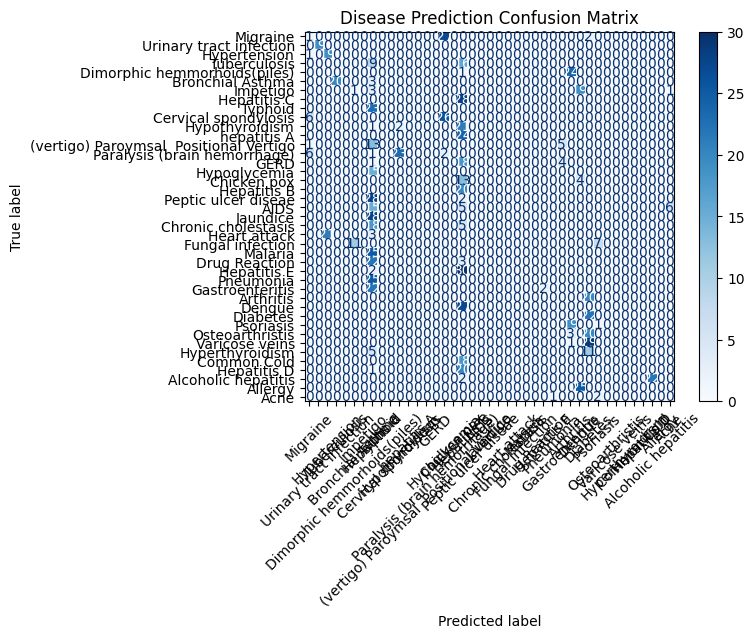

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = list(set(actual))

cm = confusion_matrix(actual, predicted, labels=labels)

plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap="Blues")

plt.title("Disease Prediction Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


In [25]:
def predict_disease(symptoms):
    prompt = f"""
Instruction: Identify the disease based on symptoms.
Symptoms: {symptoms}
Response:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    output_ids = model.generate(
        **inputs,
        max_new_tokens=40,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False
    )

    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if "Disease:" in response:
        pred = response.split("Disease:")[1].split("\n")[0].strip()
    else:
        pred = response.strip()

    return pred



demo_symptoms = "high fever, body pain, headache, joint pain, skin rash"
prediction = predict_disease(demo_symptoms)

print(" Symptoms:", demo_symptoms)
print(" Predicted Disease:", prediction)


 Symptoms: high fever, body pain, headache, joint pain, skin rash
 Predicted Disease: Instruction: Identify the disease based on symptoms.
Symptoms: high fever, body pain, headache, joint pain, skin rash
Response:
Explanation: The symptoms provided match patterns commonly associated with hepatitis B virus in the dataset.
Note: This is not medical advice. It is not medical advice.
Note: This is not


In [22]:
def predict_disease(symptoms):
    prompt = f"""Instruction: Identify the disease based on symptoms.
Symptoms: {symptoms}
Response: Disease:"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    output_ids = model.generate(
        **inputs,
        max_new_tokens=20,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False
    )

    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Extract only the disease name
    if "Disease:" in response:
        pred = response.split("Disease:")[1].split("\n")[0].strip()
    else:
        pred = response.strip()

    return pred


In [24]:
demo_symptoms = "high fever, body pain, headache, joint pain, skin rash"
prediction = predict_disease(demo_symptoms)

print(" Symptoms:", demo_symptoms)
print(" Predicted Disease:", prediction)


 Symptoms: high fever, body pain, headache, joint pain, skin rash
 Predicted Disease: Hepatitis B
